# UNet In Action

## Biomedical Image Segmentation

An implementation of the UNet to a medical image dataset to identify cell's nuclei. The dataset used for this implementation is taken from a kaggle competition @ [2018 Data Science Bowl - Find the nuclei in divergent images to advance medical discovery](https://www.kaggle.com/c/data-science-bowl-2018/).

### Why Automate Nuclei Identification?

*Identifying the cells’ nuclei is the starting point for most analyses because most of the human body’s 30 trillion cells contain a nucleus full of DNA, the genetic code that programs each cell. Identifying nuclei allows researchers to identify each individual cell in a sample, and by measuring how cells react to various treatments, the researcher can understand the underlying biological processes at work. By automating the process of nuclei identification, allows for more efficient drug testing, shortening the time it takes for each new drug to come to market.* (Ref - [2018 Data Science Bowl](https://www.kaggle.com/c/data-science-bowl-2018/))

### Original Paper<br>
The original paper can be accesss @ https://arxiv.org/abs/1505.04597

### Why Unet? <br>
*UNet, a convolutional neural network dedicated for biomedical image segmentation, was first designed and applied in 2015. In general the usecases for a typical convolutional neural network focuses on image classification tasks, where
the output to an image is a single class label, however in biomedical image visual tasks, it requires not only to distinguish whether there is a medical condition, but also to localize the area of infection i.e., a class label is supposed to be assigned to each pixel.*

### UNet Architecture <br>
**The Unet netowrk model has 3 parts:**

- The Contracting/Downsampling Path.
- Bottleneck Block.
- The Expansive/Upsampling Path.

**Contracting Path:**<br>
It consists of two 3x3 unpadded convolutions each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. After each downsampling operation, the number of feature channels are doubled.

**Bottleneck Block:**<br>
The bottleneck block connects the contracting and the expansive paths. This block performs two unpadded convolutions each with 1024 filters and prepares for the expansive path.

**Expansive Path:**<br>
Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) using transposed convolutions, a concatenation with the correspondingly feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. Transposed convolution is an upsampling technique to expand the size of images.

**Skip Connections:**<br>
The skip connections from the contracting path are concatenated with the corresponding feature maps in the expansive path. These skip connections provide higher resolution features to better localize and learn representations from the input image. They also help in recovering any spatial information that could have been lost during downsampling

**Final Layer:**<br>
At the final layer a 1x1 convolution is used to map each (64 component) feature vector to the desired number of classes.

***The entire network consists of a total of 23 convolotional layers.***


### UNet Network Diagram <br>

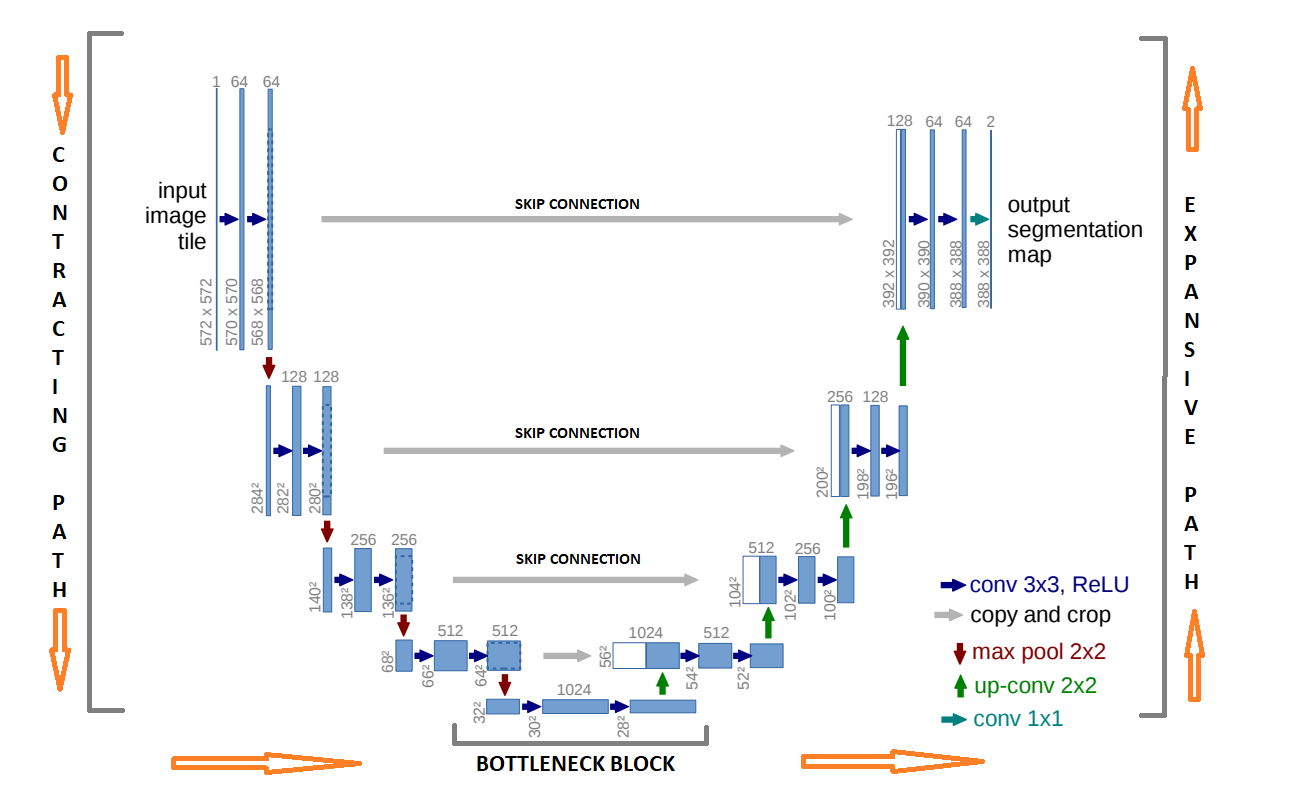

Image Reference - https://arxiv.org/pdf/1505.04597.pdf

### Original Paper Implementation
The original UNet model's implementation as described in the [paper](https://arxiv.org/pdf/1505.04597.pdf) can be found @ [UNet - Biomedical_Segmentation](https://github.com/sauravmishra1710/U-Net---Biomedical-Image-Segmentation/blob/main/UNet%20-%20Biomedical_Segmentation.ipynb)

### Applying UNet to a Realtime Dataset

#### Import Required Libraries and Utilities

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from UNetDataGenerator import  NucleiDataGenerator
from Unet import Unet

import datetime
import json
import tensorflow as tf
import tensorflow.keras.backend as K
import random

import matplotlib.pyplot as plt
from IPython.display import clear_output

import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import os
import cv2
import uuid
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

import shutil
import os

2025-06-30 16:58:47.193224: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-30 16:58:47.520456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751295527.634117  383026 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751295527.667547  383026 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-30 16:58:47.952136: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
random.seed(42)

## DATA

In [4]:
### TOTAL IMÁGENES

def count_images_in_directory(directory, extensions=[".jpg", ".png", ".jpeg"]):
    image_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if any(file.endswith(ext) for ext in extensions):
                image_count += 1
    return image_count

image_dir = "/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles"

total_images = count_images_in_directory(image_dir)

print(f"Total de imágenes encontradas: {total_images}")

Total de imágenes encontradas: 644


Aumentación de datos

In [5]:
original_dir = "/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/Resized_Organized_Cancer_Controles"
output_base_dir = "/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data"

image_mask_pairs = []

for root, dirs, files in os.walk(original_dir):
    if root.endswith("images"):
        for file in files:
            if file.endswith(".png"):
                img_path = os.path.join(root, file)
                mask_path = img_path.replace("images", "masks").replace(".png", "_1.png")
                if os.path.exists(mask_path):
                    image_mask_pairs.append((img_path, mask_path))

random.shuffle(image_mask_pairs)
total = len(image_mask_pairs)
train_split = int(0.7 * total)
val_split = int(0.15 * total)

splits = {
    "train": image_mask_pairs[:train_split],
    "val": image_mask_pairs[train_split:train_split + val_split],
    "test": image_mask_pairs[train_split + val_split:]
}

used_names = set()

for split_name, pairs in splits.items():
    for img_path, mask_path in pairs:
        parent_folder = os.path.basename(os.path.dirname(img_path))
        base_name = f"{parent_folder}_{os.path.splitext(os.path.basename(img_path))[0]}"

        original_base = base_name
        counter = 1
        while base_name in used_names:
            base_name = f"{original_base}_{counter}"
            counter += 1
        used_names.add(base_name)

        subfolder = os.path.join(output_base_dir, split_name, base_name)
        image_dir = os.path.join(subfolder, "images")
        mask_dir = os.path.join(subfolder, "masks")
        os.makedirs(image_dir, exist_ok=True)
        os.makedirs(mask_dir, exist_ok=True)

        shutil.copy(img_path, os.path.join(image_dir, f"{base_name}.png"))
        shutil.copy(mask_path, os.path.join(mask_dir, f"{base_name}_1.png"))

print("✅ División y organización completadas sin duplicados.")


✅ División y organización completadas sin duplicados.


In [6]:
import os

base_dir = "/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data"

splits = ["train", "val", "test"]

split_folder_names = {}

for split in splits:
    split_path = os.path.join(base_dir, split)
    if not os.path.exists(split_path):
        continue
    folder_names = set(os.listdir(split_path))
    split_folder_names[split] = folder_names

all_names = []
for split in splits:
    all_names.extend(split_folder_names.get(split, []))

from collections import Counter
name_counts = Counter(all_names)

repeated_names = [name for name, count in name_counts.items() if count > 1]

if repeated_names:
    print("❗ Carpetas con nombres repetidos entre splits (train, val, test):")
    for name in repeated_names:
        containing_splits = [split for split in splits if name in split_folder_names.get(split, set())]
        print(f" - {name} está en: {', '.join(containing_splits)}")
else:
    print("✅ No hay carpetas repetidas entre splits.")

✅ No hay carpetas repetidas entre splits.


In [7]:
def augment_and_save_images(image_paths, masks_paths, output_base_dir, num_augmented_copies=2, image_size=256):
    augmenter = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(0.2),
        iaa.Affine(
            rotate=(-15, 15),
            scale=(0.9, 1.1),
            shear=(-5, 5),
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)}
        ),
        iaa.SomeOf((0, 2), [
            iaa.AdditiveGaussianNoise(scale=(5, 15)),
            iaa.GaussianBlur(sigma=(0.2, 0.6)),
            iaa.Multiply((0.9, 1.1)),
        ], random_order=True)
    ])

    for img_path, mask_path in zip(image_paths, masks_paths):
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            print(f"⚠️ Error con: {img_path} o {mask_path}")
            continue

        img = cv2.resize(img, (image_size, image_size))
        mask = cv2.resize(mask, (image_size, image_size))

        for _ in range(num_augmented_copies):
            segmap = SegmentationMapsOnImage(mask, shape=img.shape)
            aug_img, aug_segmap = augmenter(image=img, segmentation_maps=segmap)
            aug_mask = aug_segmap.get_arr()

            base_name = os.path.splitext(os.path.basename(img_path))[0]
            unique_id = str(uuid.uuid4())[:8]
            subfolder = f"{base_name}_aug_{unique_id}"

            image_folder = os.path.join(output_base_dir, subfolder, "images")
            mask_folder = os.path.join(output_base_dir, subfolder, "masks")
            os.makedirs(image_folder, exist_ok=True)
            os.makedirs(mask_folder, exist_ok=True)

            cv2.imwrite(os.path.join(image_folder, f"{subfolder}.png"), aug_img)
            cv2.imwrite(os.path.join(mask_folder, f"{subfolder}_1.png"), aug_mask)

    print("✅ Aumento aplicado solo en 'train/'.")


train_dir = os.path.join(output_base_dir, "train")
train_image_paths = []
train_mask_paths = []

for folder in os.listdir(train_dir):
    subfolder = os.path.join(train_dir, folder)
    img_file = os.path.join(subfolder, "images", f"{folder}.png")
    mask_file = os.path.join(subfolder, "masks", f"{folder}_1.png")
    if os.path.exists(img_file) and os.path.exists(mask_file):
        train_image_paths.append(img_file)
        train_mask_paths.append(mask_file)

augment_and_save_images(train_image_paths, train_mask_paths, train_dir, num_augmented_copies=15)

✅ Aumento aplicado solo en 'train/'.


In [8]:
import os

base_dir = "/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data"

def count_images_in_split(split_name):
    split_path = os.path.join(base_dir, split_name)
    count = 0
    for root, dirs, files in os.walk(split_path):
        for file in files:
            if file.endswith(".png"):
                count += 1
    return count // 2  # Dividimos entre 2 porque imágenes y máscaras

train_count = count_images_in_split("train")
val_count = count_images_in_split("val")
test_count = count_images_in_split("test")

print(f"Imágenes en train: {train_count}")
print(f"Imágenes en val: {val_count}")
print(f"Imágenes en test: {test_count}")


Imágenes en train: 3600
Imágenes en val: 48
Imágenes en test: 49


Configuración de hiperparámetros

In [9]:
image_size = 256
image_channels = 3
epochs = 2000
batch_size = 8


### Train, Test and Validation sets

In [10]:
train_dir = "/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data/train"
training_data_ids = os.listdir(train_dir)  # lista de carpetas

temp_data_generator = NucleiDataGenerator(
    image_ids=training_data_ids,
    img_path=train_dir,       
    batch_size=batch_size,
    image_size=image_size
)

images, masks = temp_data_generator.__getitem__(0)
print("Batch Dimension Details:", images.shape, masks.shape)


Batch Dimension Details: (8, 256, 256, 3) (8, 256, 256, 1)


In [11]:
temp_data_generator = None

### Model Training and Validation

#### Create UNet Model 

In [12]:
# Evitar aleatoriedad

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
unet = Unet(input_shape = (image_size, image_size, image_channels), 
            filters = [32, 64, 128, 256],
            padding = "same")

model = unet.Build_UNetwork()

2025-06-30 16:59:31.825210: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-06-30 16:59:31.825255: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: beast
2025-06-30 16:59:31.825261: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: beast
2025-06-30 16:59:31.825365: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.144.3
2025-06-30 16:59:31.825384: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.144.3
2025-06-30 16:59:31.825388: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.144.3


_____ Coeficiente Dice _______

$Dice=\frac{2\cdot |A∩B|}{|A|+|B|}$ 

* A es la máscara real
* B es la máscara predicha
* ∣A∩B∣ es la intersección entre las dos máscaras (los píxeles que coinciden).
* ∣A∣+∣B∣ es la suma de los tamaños de ambas máscaras.

$Dice Loss= 1-Dice Coefficent$

In [14]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss=dice_loss, 
              metrics=[dice_coefficient])

model.summary()


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    131,200 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │     32,832 │ conv2d_9[0][0]  

 Total params: 1,925,601 (7.35 MB)

 Trainable params: 1,925,601 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

#### Data Generators

Con validación

In [16]:
base_dir = "/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/data"

training_data_ids = os.listdir(os.path.join(base_dir, "train"))
val_data_ids = os.listdir(os.path.join(base_dir, "val"))
test_data_ids = os.listdir(os.path.join(base_dir, "test"))

train_gen = NucleiDataGenerator(
    image_ids=training_data_ids, 
    img_path=os.path.join(base_dir, "train"), 
    image_size=image_size, 
    batch_size=batch_size,
    shuffle=True,
    augment=True
)

valid_gen = NucleiDataGenerator(
    image_ids=val_data_ids,
    img_path=os.path.join(base_dir, "val"),
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

test_gen = NucleiDataGenerator(
    image_ids=test_data_ids,
    img_path=os.path.join(base_dir, "test"),
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

train_steps = int(np.ceil(len(training_data_ids) / batch_size))
valid_steps = int(np.ceil(len(val_data_ids) / batch_size))
test_steps = int(np.ceil(len(test_data_ids) / batch_size))


Sin validación

In [ ]:
train_gen = NucleiDataGenerator(image_ids = training_data_ids, 
                                img_path = combined_dir, 
                                image_size = image_size, 
                                batch_size = batch_size,
                                shuffle=True,
                                augment=True)


train_steps = int(np.ceil(len(training_data_ids) / batch_size))  # Metemos int por si len(training_data_ids) % batch_size != 0, entonces el último lote se pierde, lo que puede causar que el generador se quede sin datos.

In [17]:
import imgaug.augmenters as iaa
import numpy as np

if not hasattr(np, 'bool'):
    np.bool = np.bool_


images, masks = next(iter(train_gen))
print(images.shape, masks.shape)  

print(np.min(masks), np.max(masks))

(8, 256, 256, 3) (8, 256, 256, 1)
0.0 1.0


/tmp/ipykernel_383026/1975878495.py:4: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'bool'):


#### Model Training

In [ ]:
import os

checkpoint_dir = "/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/checkpoint_FINAL"

try:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print(f"✅ Carpeta creada o ya existente: {checkpoint_dir}")
    print(f"📂 Contenido de la carpeta: {os.listdir(checkpoint_dir)}")
except Exception as e:
    print(f"❌ Error creando la carpeta: {e}")

Con validación

In [ ]:
class LivePlotCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch = []
        self.loss = []
        self.val_loss = []
        self.dice = []
        self.val_dice = []
        self.test_dice = []
        self._smoothing = 0.8  
    def _smooth(self, values):
        smoothed = []
        for v in values:
            if smoothed:
                smoothed.append(smoothed[-1] * self._smoothing + v * (1 - self._smoothing))
            else:
                smoothed.append(v)
        return smoothed

    def on_epoch_end(self, epoch, logs=None):
        self.epoch.append(epoch)
        self.loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.dice.append(logs['dice_coefficient'])
        self.val_dice.append(logs['val_dice_coefficient'])

        results = self.model.evaluate(self.model.test_gen, steps=self.model.test_steps, verbose=0)
        self.test_dice.append(results[1])
        print(f"🔍 Epoch {epoch+1} - Test Dice Coefficient: {results[1]:.4f}")

        clear_output(wait=True)
        plt.figure(figsize=(14, 5))

        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(self.epoch, self._smooth(self.loss), label='Train Loss')
        plt.plot(self.epoch, self._smooth(self.val_loss), label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss (Suavizada)')
        plt.legend()

        # Dice
        plt.subplot(1, 2, 2)
        plt.plot(self.epoch, self._smooth(self.dice), label='Train Dice')
        plt.plot(self.epoch, self._smooth(self.val_dice), label='Val Dice')
        plt.plot(self.epoch, self._smooth(self.test_dice), label='Test Dice')
        plt.xlabel('Epoch')
        plt.ylabel('Dice Coefficient')
        plt.title('Dice Coefficient (Suavizada)')
        plt.legend()

        plt.tight_layout()
        plt.show()

Sin validación

In [ ]:
class LivePlotCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch = []
        self.loss = []
        self.dice = []
        self._smoothing = 0.8

    def _smooth(self, values):
        smoothed = []
        for v in values:
            if smoothed:
                smoothed.append(smoothed[-1] * self._smoothing + v * (1 - self._smoothing))
            else:
                smoothed.append(v)
        return smoothed

    def on_epoch_end(self, epoch, logs=None):
        self.epoch.append(epoch)
        self.loss.append(logs['loss'])
        self.dice.append(logs['dice_coefficient'])

        clear_output(wait=True)
        plt.figure(figsize=(12, 5))

        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(self.epoch, self._smooth(self.loss), label='Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Train Loss (Smoothed)')
        plt.legend()

        # Dice
        plt.subplot(1, 2, 2)
        plt.plot(self.epoch, self._smooth(self.dice), label='Dice Coefficient')
        plt.xlabel('Epoch')
        plt.ylabel('Dice Coefficient')
        plt.title('Train Dice Coefficient (Smoothed)')
        plt.legend()

        plt.tight_layout()
        plt.show()


In [19]:
tf.keras.callbacks.ReduceLROnPlateau

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',      
    factor=0.5,              
    patience=80,             
    min_lr=1e-9,           
    verbose=1                
)

In [21]:
from tensorflow.keras.callbacks import Callback

class PeriodicSaver(Callback):
    def __init__(self, save_path, save_every=250):
        super().__init__()
        self.save_path = save_path
        self.save_every = save_every
        os.makedirs(save_path, exist_ok=True)

        self.history_data = {
            "epoch": [],
            "loss": [],
            "val_loss": [],
            "dice": [],
            "val_dice": []
        }

    def on_epoch_end(self, epoch, logs=None):
        self.history_data["epoch"].append(epoch)
        self.history_data["loss"].append(logs.get("loss"))
        self.history_data["val_loss"].append(logs.get("val_loss"))
        self.history_data["dice"].append(logs.get("dice_coefficient"))
        self.history_data["val_dice"].append(logs.get("val_dice_coefficient"))

        if (epoch + 1) % self.save_every == 0:
            self._save_all(f"model_epoch_{epoch + 1:04d}")

    def on_train_end(self, logs=None):
        self._save_all("model_final_contodo")

    def _save_all(self, base_name):
        self.model.save(os.path.join(self.save_path, f"{base_name}.h5"))

        self.model.save(os.path.join(self.save_path, f"{base_name}.keras"), save_format="keras")

        with open(os.path.join(self.save_path, f"{base_name}_history.json"), "w") as f:
            json.dump(self.history_data, f, indent=4)

        with open(os.path.join(self.save_path, f"{base_name}_epoch.txt"), "w") as f:
            f.write(str(self.history_data["epoch"][-1]))

        print(f"Guardado: {base_name}")



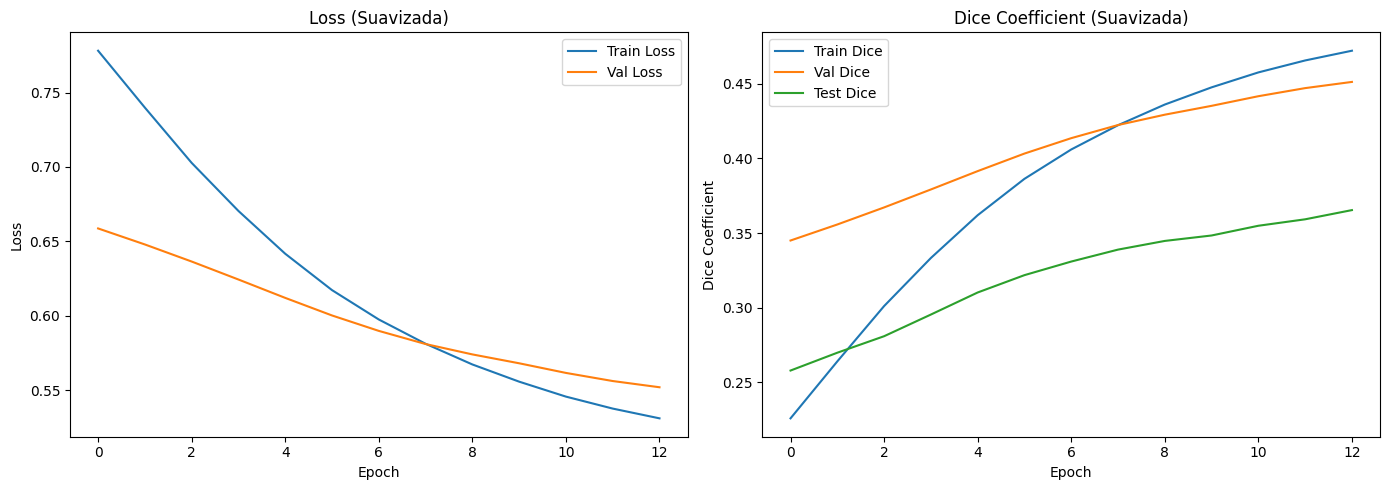

450/450 ━━━━━━━━━━━━━━━━━━━━ 616s 1s/step - dice_coefficient: 0.4923 - loss: 0.5109 - val_dice_coefficient: 0.4678 - val_loss: 0.5354
Epoch 14/2000
 41/450 ━━━━━━━━━━━━━━━━━━━━ 7:36 1s/step - dice_coefficient: 0.4730 - loss: 0.5302

KeyboardInterrupt: 

In [22]:
model.test_gen = test_gen
model.test_steps = test_steps

live_plot = LivePlotCallback()
periodic_saver = PeriodicSaver(save_path=checkpoint_dir, save_every=250)

history = model.fit(
    train_gen, 
    validation_data=valid_gen, 
    steps_per_epoch=train_steps, 
    validation_steps=valid_steps, 
    epochs=epochs,
    callbacks=[live_plot, periodic_saver]  
)

### Model Testing and Prediction Visualizations

In [ ]:
# get the test set images
test_images, test_masks = test_gen.__getitem__(1)
predicted_masks = model.predict(test_images)

predicted_masks = predicted_masks > 0.5

Guardamos

In [ ]:
final_model_path = "/home/anna/TFM/TFM-Radiomica/U-Net---Biomedical-Image-Segmentation/modelo_final_unet.h5"

model.save(final_model_path)
print(f"Modelo completo guardado en: {final_model_path}")


### DICE

In [ ]:
print("\n📊 Evaluando en conjunto de ENTRENAMIENTO...")
train_metrics = model.evaluate(train_gen, steps=train_steps, verbose=1)
print(f"🎯 Train Loss: {train_metrics[0]:.4f}")
print(f"🎯 Train Dice Coefficient: {train_metrics[1]:.4f}")


In [ ]:
print("\n📊 Evaluando en conjunto de VALIDACIÓN...")
val_metrics = model.evaluate(valid_gen, steps=valid_steps, verbose=1)
print(f"🎯 Validation Loss: {val_metrics[0]:.4f}")
print(f"🎯 Validation Dice Coefficient: {val_metrics[1]:.4f}")


In [ ]:
print("\n📊 Evaluando en conjunto de TEST...")
test_metrics = model.evaluate(test_gen, steps=test_steps, verbose=1)
print(f"🎯 Test Loss: {test_metrics[0]:.4f}")
print(f"🎯 Test Dice Coefficient: {test_metrics[1]:.4f}")
